# BLU12 - Learning Notebook 2 - Workflow

In this notebook, we will create non-personalized and personalized recommendations for a model dataset following a workflow like in a hackathon. After doing everything by hand in the previous BLUs, we will use get to use two RS libraries, [lightFM](https://making.lyst.com/lightfm/docs/index.html) and [surprise](https://surpriselib.com/).

In [1]:
# Import the necessary dependencies

# Operating System
import os
import gc

# Numpy, Pandas and Scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# LightFM
from lightfm import LightFM
from lightfm.data import Dataset as lfmDataset
from lightfm import evaluation as lfmEvaluation

# Surprise
from surprise import SVD
from surprise import Dataset as sDataset
from surprise import Reader

# Model Evaluation
from evaluation import evaluate_solution, precision_k, average_precision_k

# RAM control
from ramcontrol import check_memory_limit, memory_circuit_breaker

plt.rcParams['figure.figsize']=(4.8, 3.6)

<div class="alert alert-block alert-warning"> 
 This notebook is quite memory intensive, it uses over 3GB RAM. To prevent your PC from turning into a bonfire if you don't have enough memory, there are some steps that can be taken:
 </div>

<img src="./media/burning_pc.gif" width="500"/>

 - In cells that consume a lot of RAM, stop execution if RAM usage is too high. This can be done with the function `memory_circuit_breaker`. This function checks if the total computer RAM usage percentage is above a threshold and if it can't be lowered, the execution is stopped. You can control the percentage with `memory_limit_perc` below.
 - Frequently delete useless objects along the notebook. If a dataframe or matrix is not going to be used further on, then we can delete that object and let the garbage collector `gc` clear some RAM.
 - Change the data types to lighter alternatives: integer IDs can be converted to strings, numerical values can have smaller "bitness", for example use `np.float32` instead of `np.float64` (but be on the lookout for [overflow errors](https://numpy.org/doc/stable/user/basics.types.html#overflow-errors)), remove unused features early, etc.
 - If RAM is still an issue at this point, you can subset the original dataset to work with a smaller fraction of the data.
 - When you execute cells multiple times, it might happen that the memory usage increases at each execution, even if no new objects or data is generated. If that's the case, you should restart the kernel and re-execute the cells.
 - Ultimately, you may need more RAM. ¯\\_(ツ)_/¯ or try to run this notebook on public platforms like Kaggle or Google Collab.

In [2]:
# limit of total memory percentage that be used [0.,100.]
memory_limit_perc = 70.

## 1. Introduction
In this notebook, we are going to simulate the real-life environment of the Hackathon! We will provide you with a dataset and some tips and you are going to train, validate, and predict with a recommender system using all the knowledge acquired throughout this specialization.

### 1.1 Context
You have finished the Academy and you are hired as a data scientist in Recommenu. Recommenu is a disruptive crowdsourcing peer-to-peer mobile app experience developed to deliver a unique environment especially designed for maximum enjoyment by empowering users to engage in recipe sharing and reviewing in a paradigm shift block-chain powered AI platform.

<img src="./media/recommenu_logo.png" width="350"/>

First week on the job and the CEO of the next-unicorn-startup that hired you pitches your first task: build a recommender system to suggest users what they should prepare for their next meals. Your recommendations should be based on user reviews. She doesn't care how you do it or how it works, just that you use fancy trendy eye-catching mind-blowing AI *stuff* to promote Recommenu's name in the data science industry.

### 1.2 Technical task
After the pitch from the CEO, you talk with your lead data scientist and plan the tasks needed to fulfill the job. The company collected some data about the users and the recipes and you will need to create the recommender system that is effective enough so that your users will always know what to cook. The main task is to find the best recommendations for each user.

### 1.3 Evaluation

Your lead DS will keep some of the data as a test dataset (in which you will estimate production performance) and gives you the remaining data.

The expected output is 50 recommendations for each user. The recommendations are compared with the validation data set and evaluated using map@50.

## 2. Data

### 2.1 Step -1: Inspect the data
The data is in the `data` folder. As a good data scientist, your first step is to validate that the data you have will be good enough to proceed.

The files we have available for the training stage are:
* `RAW_interactions_train.csv` with the user reviews
* `RAW_recipes.csv` with the recipe metadata

We also have an example output file:
* `example_output.csv` is an example of the output, the first column is the user id and the remaining 50 columns are the recommended recipe ids

The best approach is to look at the raw files and print out the first rows of each file just to get an overall sense of what we have. Remember what you've learned in the data wrangling specialization!

In [3]:
print("RAW_interactions_train.csv \n")
!head -3 data/RAW_interactions_train.csv

RAW_interactions_train.csv 

user_id,recipe_id,review_date,rating,comment
2133146,40767,2012-01-03,0,"i'm yet to try this recipe but my dad makes one very similar. it's definitely sweetened condensed milk (because its thick and sugary), and the sugar has to be simmered until its melted completely. my father also used golden syrup on top of the ingredients listed here. you can also add a small portion of water once the ingredients are thoroughly combined and sugar melted and place back on low heat to thicken up again"
1619510,169999,2011-06-18,5,"Made this many times, absolutly love it. Like my corn on the raw side took kpfen advise and only cooked it for 15 minutes...."


In [4]:
print("RAW_recipes.csv\n")
!head -2 data/RAW_recipes.csv

RAW_recipes.csv

name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
bananas 4 ice cream  pie,70971,180,102353,2003-09-10,"['weeknight', 'time-to-make', 'course', 'main-ingredient', 'preparation', 'pies-and-tarts', 'desserts', 'lunch', 'snacks', 'no-cook', 'refrigerator', 'kid-friendly', 'frozen-desserts', 'pies', 'chocolate', 'dietary', 'inexpensive', 'equipment', 'number-of-servings', 'technique', '4-hours-or-less']","[4270.8, 254.0, 1306.0, 111.0, 127.0, 431.0, 220.0]",8,"['crumble cookies into a 9-inch pie plate , or cake pan', 'pat down to form an even layer', 'drizzle 1 cup of chocolate topping evenly over the cookies with a small spoon', 'scoop the vanilla ice cream on top of the chocolate and smooth down', 'cover with half of the sliced bananas', 'top with strawberry ice cream', 'cover and freeze until firm', 'before serving , top with 1 / 4 cup chocolate topping , whipped cream , and sliced bananas']",,"['chocolate sandwi

In [5]:
print("example_output.csv \n")
!head -1 data/example_output.csv

example_output.csv 

4470,12985,304842,293304,414,25150,314086,68212,217471,14397,177172,54386,315812,319911,243769,302247,86545,2078,16220,310418,302369,289658,221730,333259,311604,52478,307202,329834,25323,337625,277126,87433,170541,212702,24825,212017,348629,127365,241705,183796,341456,170222,207916,384072,132813,107193,188549,362714,138672,21771,339689,38941,177486,244143,285387,157386,307140,126831,302031,181854,192716,334187,57500,165401,305991,207935,351764,105434,45592,187097,311262,266750,109807,90822,311702,208383,52176,243307,97972,19682,353035,30292,72314,105694,108137,335634,55364,84395,147076,261596,49469,39842,245936,69165,202995,49781,142602,223714,122591,333064,149655,11147,69227,252967,8402,180413,291341,321987,79814,167248,168430,30643,36589,362643,165753,247135,378274,172483,353700,93787,177574,150116,250930,245012,129495,307414,315425,340072,334240,114624,39401,183790,348308,47391,242558,186377,100897,248603,142745,261901,162388,345265,263933,130077,368393,57225,35

### 2.2 Step 0: Load the data
After validating that the data is good enough, we start building the ratings matrix. Our strategy is to get a non-personalized recommender system as a baseline. This avoids the cold start problem and allows us to predict both for existing and new users.

We will load the rating data and the recipe metadata.

In [6]:
train_path = os.path.join('data', 'RAW_interactions_train.csv')
data = pd.read_csv(train_path)
data.head()

,user_id,recipe_id,review_date,rating,comment
0,2133146,40767,2012-01-03,0,i'm yet to try this recipe but my dad makes on...
1,1619510,169999,2011-06-18,5,"Made this many times, absolutly love it. Like ..."
2,1072593,111434,2014-08-07,5,The family&#039;s divided on this one. The ra...
3,72489,15059,2004-12-20,5,C'est si bon! These are delicious and delecta...
4,109110,336205,2013-06-10,0,This wasn&#039;t to our taste.


In [7]:
recipe_meta_path = os.path.join('data', 'RAW_recipes.csv')
recipes = pd.read_csv(recipe_meta_path)
recipes.head()

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,bananas 4 ice cream pie,70971,180,102353,2003-09-10,"['weeknight', 'time-to-make', 'course', 'main-...","[4270.8, 254.0, 1306.0, 111.0, 127.0, 431.0, 2...",8,"['crumble cookies into a 9-inch pie plate , or...",NaN,"['chocolate sandwich style cookies', 'chocolat...",6
1,beat this banana bread,75452,70,15892,2003-11-04,"['weeknight', 'time-to-make', 'course', 'main-...","[2669.3, 160.0, 976.0, 107.0, 62.0, 310.0, 138.0]",12,"['preheat oven to 350 degrees', 'butter two 9x...",from ann hodgman's,"['sugar', 'unsalted butter', 'bananas', 'eggs'...",9
2,better than sex strawberries,42198,1460,41531,2002-10-03,"['weeknight', 'time-to-make', 'course', 'main-...","[734.1, 66.0, 199.0, 10.0, 10.0, 117.0, 28.0]",8,['crush vanilla wafers into fine crumbs and li...,simple but sexy. this was in my local newspape...,"['vanilla wafers', 'butter', 'powdered sugar',...",7
3,better then bush s baked beans,67547,2970,85627,2003-07-26,"['weeknight', 'time-to-make', 'course', 'main-...","[462.4, 28.0, 214.0, 69.0, 14.0, 29.0, 23.0]",9,['in a very large sauce pan cover the beans an...,i'd have to say that this is a labor of love d...,"['great northern bean', 'chicken bouillon cube...",13
4,chinese candy,23933,15,35268,2002-03-29,"['15-minutes-or-less', 'time-to-make', 'course...","[232.7, 21.0, 77.0, 4.0, 6.0, 38.0, 8.0]",4,['melt butterscotch chips in heavy saucepan ov...,"a little different, and oh so good. i include ...","['butterscotch chips', 'chinese noodles', 'sal...",3


### 2.3 Step 1: Interaction data exploration

Let's explore the interaction data.

In [8]:
# How many ratings do we have in total?
# Tip: The ":," at the end of the f-string adds the thousand separator.
print(f"We have {len(data):,} ratings in total.")

We have 163,065 ratings in total.


In [9]:
# How many recipes were rated?
print(f" We have {data['recipe_id'].unique().size:,} recipes rated.")

 We have 30,695 recipes rated.


In [10]:
# How many users rated at least one recipe?
print(f" We have {data['user_id'].unique().size:,} users that rated at least one recipe.")

 We have 58,884 users that rated at least one recipe.


Let's plot the rating distribution:

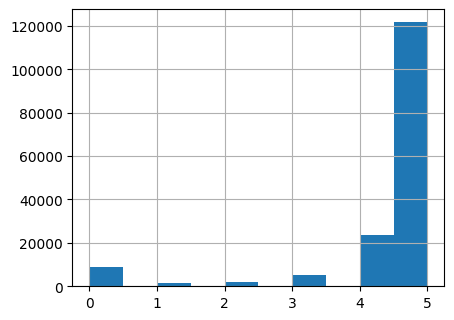

In [11]:
# Plotting the rating distribution.
data["rating"].hist();

We are expecting ratings between 1 and 5, but we have some 0 values. Let's check these cases.

In [12]:
data.loc[data["rating"] == 0][80:120]

,user_id,recipe_id,review_date,rating,comment
1560,2002194880,36431,2018-06-22,0,How do you store them after they are done? Wha...
1584,2002171413,449747,2018-05-31,0,Cook uncovered and in a low pan (use a good qu...
1600,162285,103281,2005-02-21,0,I am from Bavaria and my mom used to make it a...
1670,2164272,411501,2017-03-06,0,I am so excited!!! Shawn can't wait for me to ...
1674,1759082,15411,2010-12-15,0,"Quick, Easy, & using ingredients that you ALWA..."
1676,2001467157,48635,2017-04-01,0,Do I have to use the baking soda???
1678,111336,693,2005-08-24,0,"Easy, quick ""hot dish""."
1683,261899,211710,2012-10-14,0,My family loved this..So tonight I'm trying wi...
1698,2206320,475041,2012-03-12,0,That sounds yummy!!!
1701,159782,334688,2011-01-18,0,"Well, it doesn't get much easier than this. Ad..."


When the rating is 0, some comments are negative but most are positive. Let's read some examples.

In [13]:
data.loc[data["rating"] == 0, "comment"][1917]

'WOW...This was incredible, I wish I could give a hundred stars. My Boyfriend said we would never eat out Mexican again. So five stars from him and five from me...my daughter even ate every bite! This is a great recipe. I of course added just a little spice, 1 Tbsp of cumin to the chicken and onions. Perfect recipe, the sauce is beautiful when it comes together, Everything was perfect. Thank you for sharing!'

In [14]:
data.loc[data["rating"] == 0, "comment"][1732]

'Seriously? The worst recipe ever!! Made it yesterday. Never ever experienced such a worse mac n cheese sauce:-(\nTotal flour taste! Like sb else already noticed: your family will hate you for that.\nGoing to find me another recipe now or have to stick to the craft company.'

In [15]:
data.loc[data["rating"] == 0, "comment"][2054]

'Great recipe!!! Super easy & quick & DELICIOUS!!! My family loved it!!!'

In [16]:
data.loc[data["rating"] == 0, "comment"][1768]

'How much water should I add?'

In [17]:
data.loc[data["rating"] == 0, "comment"][2192]

"I can't rate this yet.  Unfortunately, my crock pot died while making and by the time I found out I had to dump the whole thing for safety reasons.  I did try remaking but having less wine (using 1/2 wine, half homemade beef broth) it wouldn't be fair to rate.  I'm so sorry, Chohettz.  \r\nMade for PAC, 2008."

While some comments are positive, others are negative. One user even commented that they didn't rate the recipe. Let's see if there are more cases.

In [18]:
data.loc[(data["rating"] == 0) & (data["comment"].str.contains("rate"))].head()

,user_id,recipe_id,review_date,rating,comment
58,441655,443523,2010-12-07,0,Delicious!! I added a hint of peppermint extra...
335,386585,345396,2009-02-23,0,"I will not give any stars, because I messed th..."
471,31803,56621,2005-09-11,0,These turned out great! We can't buy Grape Nut...
883,136997,229960,2007-06-29,0,"I was intrigued by this, but I don't think it ..."
1435,1584953,236448,2011-02-22,0,I didn't rate this because I realized I had th...


In [19]:
## A particular case
data.loc[data["rating"] == 0, "comment"][1435]

"I didn't rate this because I realized I had the same recipe already saved on another recipe site, going back to 2006. Anyway, it's really good"

All of these comments lead us to believe that zero rating means that the user purposely did not rate the recipe (maybe they didn't follow the recipe and feel that they shouldn't rate it) or forgot to rate it regardless of liking the recipe.

There doesn't seem to be a consistent meaning behind zero ratings. Recipes with rating 0 can be excellent, horrible or something in between. For this reason, reviews with zero rating should be removed from our data.

Note: In a more advanced approach, you might try to use sentiment analysis (or other techniques) to predict the rating when a user does not rate a recipe.

In [20]:
# Removing 0 ratings
nr_reviews_orig = data.shape[0]
data = data.copy().loc[(data["rating"] != 0)]
nr_reviews_new = data.shape[0]
print(f"{nr_reviews_orig - nr_reviews_new:,} reviews with rating 0 where removed from training data.")

8,984 reviews with rating 0 where removed from training data.


You might have noticed that the review date goes from from January 2000 to December 2018. This is a huge time interval! 

In [21]:
## Training data interval range
print(f"The earliest review was written on {data['review_date'].min()}.")
print(f"The lastest review was written on {data['review_date'].max()}.")

The earliest review was written on 2000-03-13.
The lastest review was written on 2018-12-19.


For most cases, using old data is a risk. Old data might not accurately reflect the current relationship between features and target. We say that we have **[concept drift](https://machinelearningmastery.com/gentle-introduction-concept-drift-machine-learning/)** when the relationship between inputs and outputs changes over time. 

In our case, we are going to assume that the user taste does not change significantly over time. In a professional setting, we should back this assumption with data or deal with concept drift.

We also remove the comment column, it won't be necessary for the construction of the ratings matrix.

In [22]:
data = data.drop(columns=["review_date", "comment"])

### 2.4 Train/validation split

We are splitting the available data into training and validation data. The validation data can be used to compare models before submitting the recommendations to the portal. Note that the data points that we are predicting are given by a user-item pair. The user-item pairs between the train and validation sets will be different, but a given user or item can appear in both sets.

A smarter way to do the split would be make sure that we have all items and users in both sets. That would also be more similar to a real life situation where we're predicting non-existing ratings for existing users. For now, we're just going to deal with items or users missing from the train set later on.

In [23]:
data_train, data_val = train_test_split(data, test_size=0.4, random_state=123)

#### 2.4.1 Training set
Let's look at basic stats for the training set:

In [24]:
# How many ratings do we have in total?
# Tip: The ":," at the end of the f-string adds the thousand separator.
print(f"We have {len(data_train):,} ratings in total.")

We have 92,448 ratings in total.


In [25]:
# How many recipes were rated?
print(f" We have {data_train['recipe_id'].unique().size:,} recipes rated.")

 We have 21,358 recipes rated.


In [26]:
# How many users rated at least one recipe?
print(f" We have {data_train['user_id'].unique().size:,} users that rated at least one recipe.")

 We have 36,431 users that rated at least one recipe.


#### 2.4.2 Validation set
And the validation set:

In [27]:
# How many ratings do we have in total?
# Tip: The ":," at the end of the f-string adds the thousand separator.
print(f"We have {len(data_val):,} ratings in total.")

We have 61,633 ratings in total.


In [28]:
# How many recipes were rated?
print(f" We have {data_val['recipe_id'].unique().size:,} recipes rated.")

 We have 16,662 recipes rated.


In [29]:
# How many users rated at least one recipe?
print(f" We have {data_val['user_id'].unique().size:,} users that rated at least one recipe.")

 We have 27,073 users that rated at least one recipe.


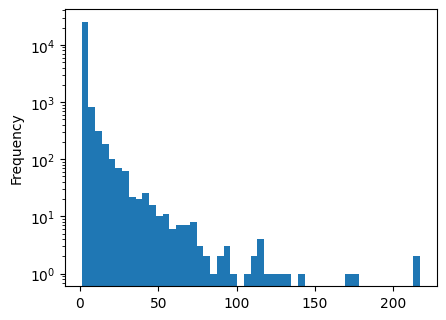

In [30]:
# How many recipes were rated by each user?
data_val.groupby('user_id').rating.apply(len).plot.hist(bins=50,log=True);

Most users rated just a few recipes, in fact about half the ratings in the validation are from users who rated just one recipe. If we want to use metrics like `map@k`, our test users must have at least k positive ratings. In our case, it's k=50, as we're using map@50.

One might argue that by selecting such users for testing, we'll have selection bias because we are specifically ignoring users with fewer ratings. This is a consideration that you should take into account especially if you want to evaluate the performance of recommendations to new users. 

This functions selects positive ratings from users with at least 50 positive reviews from the validation data.

In [31]:
def select_frequent_reviewers(df: pd.DataFrame, min_nr_reviews: int = 50, min_rating: int = 3):
    """
    Select users with at least min_nr_reviews reviews with a rating larger than min_rating.
    """
    
    # Select only positive reviews
    df_positive = df.copy().loc[df["rating"] >= min_rating]

    # Select users with more than min_nr_reviews positive reviews
    user_review_count = df_positive.groupby(by=["user_id"])["recipe_id"].count()
    test_users_list = list(user_review_count[user_review_count > min_nr_reviews].index)

    # Select ratings from users specified above
    df_restrict = df_positive.loc[df_positive["user_id"].isin(test_users_list)]
    
    return df_restrict

data_val_final = select_frequent_reviewers(data_val)
data_val_final.head()

,user_id,recipe_id,rating
128079,560491,33671,5
10492,169430,436201,5
154262,107583,335113,5
92987,133174,141443,5
23908,160974,43104,5


Here we create a list of validation data user ids for later use:

In [32]:
users_val = sorted(data_val_final["user_id"].unique())
print(f"We are validating recommendations with {len(users_val)} users.")
print('user_ids:', users_val)

We are validating recommendations with 73 users.
user_ids: [4470, 5060, 8688, 9869, 17803, 29782, 37449, 37779, 39835, 41578, 47559, 50969, 52543, 53932, 58104, 80353, 88099, 89831, 95743, 101823, 104295, 107135, 107583, 126440, 128473, 131126, 133174, 136997, 140132, 145352, 149363, 157425, 158086, 160974, 166642, 169430, 169969, 173579, 174096, 176615, 179133, 197023, 198154, 199848, 204024, 222564, 226066, 226863, 280271, 286566, 296809, 305531, 324390, 369715, 383346, 386585, 400708, 424680, 428885, 452355, 452940, 461834, 482376, 486725, 498271, 542159, 560491, 632249, 653438, 679953, 844554, 1072593, 1179225]


Notice that even though we selected 40% of the data to be used for validation, are left with a tiny number of users to validate our results. The validation data is too small to have an accurate evaluation of the models. With more data and a more robust cross-validation method this shouldn't be a problem. 

### 2.5 Create the validation 

We will now find the 50 best rated recipes for each of the 73 selected users. This will be our ground truth for comparing the predictions. The result is a dataframe with a row for each user where the recipe ids are ordered according to the rating.

In [33]:
# nr of recommendations per user
k_top = 50

def top_items_per_user(df: pd.DataFrame, user_col: str, rating_col:str, k_top: int = 50):
    """
    Creates a ranking of k_top recipes according to rating for each user.
    Does not take into account equal ratings.

    Returns:
        df_recommendations (pd.DataFrame): each row is a user, the first value is the user id,
                                           followed by recipe ids sorted by rank
    """
    df_sorted=df.copy().sort_values([user_col,rating_col],ascending=False)
    df_k_top=df_sorted.groupby(user_col).tail(k_top)
    df_k_top.loc[:,['rank']]=pd.Series(list(range(50,0,-1))*len(df_k_top[user_col].unique()),
                                       index=df_k_top.index)

    df_recommendations = df_k_top.pivot(index=user_col, columns="rank", values="recipe_id")
    df_recommendations = df_recommendations.reset_index()
    df_recommendations.columns = np.arange(len(df_recommendations.columns))
    return df_recommendations

val_recommendations = top_items_per_user(data_val_final, "user_id", "rating", k_top=k_top)
val_recommendations.head()

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,4470,65020,76661,17326,336760,30004,231677,66191,146160,79353,...,26942,33570,22267,252288,64698,25800,68491,52275,31713,180609
1,5060,93190,189415,83770,211506,103345,208092,16761,43588,11357,...,256418,86936,316609,22739,65077,127858,57177,23034,27760,12794
2,8688,133548,107636,218341,226188,15509,25806,247633,51757,214533,...,17566,185498,55768,29210,29544,166111,39072,52646,50022,49942
3,9869,34853,21349,13982,194664,28440,95007,47616,152072,12787,...,48217,44572,12354,31482,31710,25519,189655,10367,59510,24019
4,17803,272643,304533,181004,3370,142253,430357,268736,153885,441222,...,107498,251389,112282,192869,211485,256044,305634,16961,121271,25556


### 2.6 Save the validation

Here we create a function to store recommendations into a `.csv` file and store our validation.

In [34]:
def save_recommendations(df: pd.DataFrame, file_name: str):
    """
    Save recommendation dataframe as .csv.
    """
    
    file_path = os.path.join("data", f"{file_name}.csv")
    df.to_csv(file_path, index=False, header=False)
    print(f"Recommendations were saved in file {file_name}.csv.")
    
save_recommendations(val_recommendations, "validation_recommendations")

Recommendations were saved in file validation_recommendations.csv.


Now that we have the validation for comparing the results from any RS we will create, we can proceed to design the RS.

## 3. Non-personalized recommendations

For our non-personalized baseline, we'll select the most popular recipes from all the rated recipes. Our definition of most popular in this case will be the recipes that have the best score but are also rated more often. We will calculate the average score and the number of times a recipe was rated, sort the recipes, and select the 50 with the highest rating ordered by the number of times they were rated. We can directly find the most popular recipes without creating a rating matrix. 

In [35]:
def non_pers_reco_order(data: pd.DataFrame,
                        item_col: str,
                        rating_col:str,
                        k_top: int = 50,
                        aggregation: list() = ["mean", "count"]):
    """
    Create an ordered list of non-personalized recommendations, from best rated to worst rated.
    """
    non_pers_ratings = data.groupby(by=[item_col])[rating_col].agg(aggregation)
    
    #The resulting column names might be different than the specified with the aggregation parameter.
    try:
        non_pers_ratings = non_pers_ratings.sort_values(by=aggregation, ascending=False).head(k_top)
    except KeyError as e:
        print(e)
        print("Check if aggregation argument results in valid column names.")
        print(f"aggregation = {aggregation}\nrating columns = {non_pers_ratings.columns}")
        raise e
        
    non_pers_reco_list = non_pers_ratings.index.to_list()
    return non_pers_reco_list


non_pers_recommendations = non_pers_reco_order(data_train, "recipe_id", "rating", k_top=k_top)
print(non_pers_recommendations)

[154351, 515167, 55309, 487111, 18446, 24768, 69051, 104292, 153877, 20233, 87047, 497261, 29184, 36041, 110397, 114956, 495202, 61040, 61514, 57549, 474694, 11548, 50498, 51058, 98846, 112299, 496573, 109287, 157841, 191225, 55634, 66990, 82102, 105545, 190733, 269611, 272181, 284630, 518145, 37758, 73825, 100450, 146563, 163220, 209670, 228909, 13275, 50958, 74182, 94087]


### 3.1 Output non-personalized solution

Here we create recommendations for the specified users based on the non-personalized recommendations obtained above. Basically, we recommend the same to everyone.

In [36]:
def non_pers_reco_output(user_id_list:list, non_pers_reco_list:list):
    """
    Creates a non-personalized recommendations dataframe for specified users.
    """
    nr_test_users = len(user_id_list)
    user_id_df = pd.DataFrame(user_id_list, columns = ["user_id"])
    non_pers_reco_repeated =  pd.DataFrame(pd.DataFrame(non_pers_reco_list).T.values.repeat(nr_test_users, axis=0))
    non_pers_reco_output = pd.concat([user_id_df, non_pers_reco_repeated], axis=1)
    
    # Reset columns numbering. Useful later.
    non_pers_reco_output.columns = np.arange(len(non_pers_reco_output.columns))
    
    return non_pers_reco_output

Let's test for a couple of users

In [37]:
non_pers_reco_output([452355, 18540, 2743667], non_pers_recommendations)

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,452355,154351,515167,55309,487111,18446,24768,69051,104292,153877,...,73825,100450,146563,163220,209670,228909,13275,50958,74182,94087
1,18540,154351,515167,55309,487111,18446,24768,69051,104292,153877,...,73825,100450,146563,163220,209670,228909,13275,50958,74182,94087
2,2743667,154351,515167,55309,487111,18446,24768,69051,104292,153877,...,73825,100450,146563,163220,209670,228909,13275,50958,74182,94087


We created a recommendation dataframe in the format of our example output file. Each row represents a user, the first column is the user id and the remaining columns are the recommended recipe ids ordered and numbered from best recommended to least recommended. Now we will produce recommendations for the validation users.

### 3.2 Non-personalized recommendations for validation data

We just need to evoke the function `non_pers_reco_output` with the validation users and the non-personalized recommendations.

In [38]:
non_pers_reco_solution_val = non_pers_reco_output(users_val, non_pers_recommendations)
save_recommendations(non_pers_reco_solution_val, "non_personalized_recommendations_VAL")

Recommendations were saved in file non_personalized_recommendations_VAL.csv.


Now the most exciting part - how good are the recommendations? We will use the function `evaluate_solution` with the solution file name as the first argument and the ground-truth as the second argument to calculate map@50. The function returns the map@50 and in addition a list of average precisions for all the users.

In [39]:
## Second argument is the recommendation file to compare
map50_val_np, map50_val_np_list = evaluate_solution('non_personalized_recommendations_VAL', 'validation_recommendations')
print(map50_val_np, map50_val_np_list)

0.00583057274805967 [0.0, 0.0, 0.0, 0.0, 0.0, 0.03562696390944565, 0.0, 0.0088142028578581, 0.0, 0.0, 0.0, 0.0025295889000065026, 0.013664943211518364, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.02008194520266223, 0.0, 0.0, 0.014464943211518365, 0.013664943211518364, 0.0, 0.0, 0.014464943211518365, 0.0, 0.0, 0.15449250233994755, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00649292283069572, 0.0, 0.027919893202374937, 0.0, 0.0, 0.024019526902008637, 0.0, 0.03562696390944565, 0.0025295889000065026, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0020851444555620583, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03562696390944565, 0.0, 0.0, 0.0, 0.0, 0.011440685987261138, 0.0, 0.0, 0.0, 0.0020851444555620583, 0.0]


Not a bad baseline, we got at least some recommendations right!

## 4. Collaborative recommendations with LightFM

Now that we have a baseline model, we can try collaborative filtering. We are going to use [LightFM](https://making.lyst.com/lightfm/docs/home.html) which is a library implementing matrix factorization methods.

Matrix factorization means that a matrix is expressed as a product of other matrices. We have used matrix factorization in dimension reduction methods in the NLP specialization. In the case of recommender systems, we look for a factorization of the ratings matrix. As the factorization permits to calculate the original matrix, it allows us to fill in the missing ratings that we want to predict.

### 4.1 Create the dataset
We start by using the lightFM [Dataset](https://making.lyst.com/lightfm/docs/lightfm.data.html?highlight=dataset#lightfm.data.Dataset) function to create the user and item mapping that defines the vectorial space of the rating matrix. Note that we include all recipe ids, also from the val set because to be able to make predictions, we need to have all users in the same feature space. If a test user had different features (recipe ids in this case) than the training users, we wouldn't be able to predict.

In [40]:
# Notice the alias lfmDataset() instead of the standard Dataset()
# Used to distiguish between lightFM Dataset() and another Dataset() that we'll use later.
# We are sorting the user and item ids just so that it's prettier.
lfmdataset = lfmDataset()
lfmdataset.fit(sorted(data_train['user_id'].unique()), sorted(data['recipe_id'].unique()))

We can check that the vectorial space is defined as expected:

In [41]:
num_users, num_items = lfmdataset.interactions_shape()
print('Num users: {:,}, num_items {:,}.'.format(num_users, num_items))

Num users: 36,431, num_items 29,670.


The mapping between external user IDs (the ones in our data) and the internal user IDs can be obtained with the method `.mapping()`. The same applies for items. The method returns a mapping for ids and features. In the case of collaborative recommenders, the ids are the features (so-called indicator features), so both mappings are the same.

In [42]:
user_id_map, user_feature_map, item_id_map, item_feature_map = lfmdataset.mapping()

We will also need the reverse mappings:

In [43]:
item_id_map_reverse = {v: k for k, v in item_id_map.items()}
user_id_map_reverse = {v: k for k, v in user_id_map.items()}

Now we can create the ratings matrix with the `build_interactions` method. The argument is an iterable of tuples of the form (user_id, item_id) or (user_id, item_id, weight) where weight is what we call rating.

The method returns two COO matrices, the interactions and the weights matrices. The interactions matrix indicates which user-item pairs interacted, i.e. where we have existing ratings, so it's like the ratings matrix, but all nonzero entries are 1. The weights matrix is what we called the ratings matrix until now.

In [44]:
(interactions, weights) = lfmdataset.build_interactions((row for row in data_train.to_numpy()))

weights

<COOrdinate sparse matrix of dtype 'float32'
	with 92448 stored elements and shape (36431, 29670)>

### 4.2 Fit the model
We now define the model that is going to predict the recommendations. The [lighFM](https://making.lyst.com/lightfm/docs/lightfm.html#lightfm) model learns the user representations in the item space that encode user preferences for items. The optimization proceeds via the stochastic gradient descent. We select the `warp` loss function as it is [recommended](https://making.lyst.com/lightfm/docs/lightfm.html#id2) for optimizing the top of the recommendations list (precision@k), which is our case.

In [45]:
lfmodel = LightFM(loss='warp')

We fit the model with our interactions and ratings data. As you can see, the syntax of LightFM is the same as for scikit-learn. We can choose to use just the interactions matrix or include also the sample weights. The interactions matrix already has a lot of information because users are more likely to interact with items they expect to like.

In [46]:
lfmodel.fit(interactions, sample_weight=weights)

### 4.3 Predictions
After fitting come the predictions. The [predict](https://making.lyst.com/lightfm/docs/lightfm.html#lightfm.LightFM.predict) method calculates the rating of each item for the given users.

If we are predicting for a user which the model has already seen and so is included in the ratings matrix, we need to supply the user id and the item ids for which we'd like the predictions.

The predictions are done for a user-item pairs and this reflects also in the syntax of the `predict` method. If you want to predict for two users, you need to repeat the item ids. For example, the syntax for predicting items 7, 8, 9 for users 0 and 1 is `predict(user_ids=lfm.predict(user_ids=[0, 0, 0, 1, 1, 1], item_ids=[7, 8, 9, 7, 8, 9])`.

Let's predict for the first user in the ratings matrix. This user has the internal user id 0. We can find the original user id with the reverse map dictionary.

In [47]:
user_id_map_reverse[0]

1533

Here we predict for this user and the first three items in the ratings matrix.

In [48]:
lfmodel.predict(user_ids=0, item_ids=[0,1,2])

array([-0.38904777, -1.1438911 , -1.3138323 ], dtype=float32)

The predicted scores are not the ratings, they are just used to compare the items for the given user. The scores can also be negative. If we are predicting for several users, the scores cannot be compared between users, the ranking is calculated for each user separately.
 
If we want to predict for all the items in the ratings matrix, we do it like this:

In [49]:
lfmodel.predict(user_ids=0, item_ids=np.array(range(num_items)))

array([-0.38904777, -1.1438911 , -1.3138323 , ..., -1.234284  ,
       -1.2034111 , -1.259371  ], dtype=float32)

If we have users which are not in the ratings matrix, we need to supply a csr matrix of user features. In our case, all the users from the final validation set are also in the train set, but let's imagine that we have such a user and their ratings just for the sake of the example.

We're going to calculate predictions for the first user from the validation set with the id 4470. First we construct the matrix of user features - the ratings from the `data_val` dataframe for the given user.

In [50]:
new_user_id_ext=4470
new_user_data=data_val[data_val.user_id==new_user_id_ext]
# transform the item id to internal ids
new_user_item_ids=new_user_data.recipe_id.map(item_id_map)
# construct the item features matrix
new_user_features=np.zeros(num_items)
new_user_features[new_user_item_ids]=new_user_data.rating
new_user_features

array([0., 0., 0., ..., 0., 0., 0.])

Next we predict. We use 0 for the user id (or 0, 1, 2, ... if we have more new users) and we supply the use features. Like this, the model knows that this is a new user and not the existing user with the user id 0.

In [51]:
new_user_preds=lfmodel.predict(user_ids=0, item_ids=np.array(range(num_items)), user_features=csr_matrix(new_user_features))
new_user_preds

array([-285.96283, -281.7072 , -283.8933 , ..., -282.43283, -283.08655,
       -279.35614], dtype=float32)

Ok, that was the hypothetical situation of a new user, but this user actually exists, so we're going to get their predictions for real now.

In [52]:
user_id_ext = 4470
user_id_int = user_id_map[user_id_ext]
collab_preds_4470 = lfmodel.predict(user_ids=user_id_int, item_ids=np.array(range(num_items)))
collab_preds_4470

array([-1.4202138, -2.0770044, -2.2205834, ..., -2.217663 , -2.1790965,
       -2.1855004], dtype=float32)

Now that we have the predictions, we need to select the best items. We sort the items by the predicted score and select the `k_top` best items. We also need to transform the item ids to external to compare them for our known validation set data.

But, there's one more detail - we don't want to include items which the user already rated. We're going to set the scores for these predictions to null values, so they end up at the end of the array after sorting and we can remove them.

In [53]:
k_top = 50

# set scores for existing rating to NaN
row = interactions.nonzero()[0] # row indices with existing ratings
col = interactions.nonzero()[1] # col indices with existing ratings
int_item_id = col[np.asarray(row==user_id_int).nonzero()]
collab_preds_4470[int_item_id]=np.nan

# sort and remove the NaNs
collab_preds_4470_items = np.argsort(-collab_preds_4470)[:k_top]

# convert item ids to external
collab_preds_4470_items_ext=[item_id_map_reverse[i] for i in collab_preds_4470_items]
print(collab_preds_4470_items_ext)

[107786, 129926, 26110, 150863, 63689, 92095, 28768, 97496, 66121, 106251, 200296, 27210, 8701, 52035, 3470, 33921, 150384, 37413, 8782, 63828, 52253, 30081, 80536, 51537, 79944, 205890, 44232, 54351, 66241, 44888, 42094, 35805, 1356, 25730, 42780, 102617, 9494, 78579, 55768, 10125, 32147, 29884, 13546, 13949, 52272, 155021, 101954, 155018, 36984, 125399]


OK, now that we know how this works, we can recommended recipes for more users. We're going to ignore the users that exist only in the validation set and not in the train set because that is not likely to happen in real settings (but there is a function to construct user features for such cases in the utils file). 

We will distinguish two kinds of users - existing and new. Existing users have ratings and the model knows them, so we can make a prediction. New users don't have any ratings, so the best we can do is give them non-personalized recommendations. Here comes a rather long function to make collaborative predictions (which should have been split into more parts because, ehm, clean code):

In [54]:
def predict_collab_lfm(user_id: list, model, k_top=50, num_items=num_items):
    """
    Makes collaborative predictions with the trained lightFM model for new users.
    """
    # divide the users into existing and new, convert existing to internal ids
    existing = [i for i in user_id if i in user_id_map.keys()]
    new = [i for i in user_id if i not in user_id_map.keys()]

    # make predictions for new users
    df_new = non_pers_reco_output(new, non_pers_recommendations)
    
    # make predictions for existing users
    existing_int = [user_id_map[i] for i in existing]
    user_ids = [i for i in existing_int for j in range(num_items)]
    item_ids = [i for j in existing_int for i in range(num_items)]
    existing_preds=model.predict(user_ids, item_ids)

    # set scores for existing ratings to NaN
    existing_preds = existing_preds.reshape(len(existing_int),-1)
    row = interactions.nonzero()[0] # row indices with existing ratings
    col = interactions.nonzero()[1] # col indices with existing ratings
    mask = np.isin(row, existing_int) # where the existing user ids are
    # mapping from internal ids to rows in the prediction score array
    user_score_row_map = dict(zip(existing_int,np.argsort(existing_int)))
    row_mask = [user_score_row_map[i] for i in row[mask]]
    existing_preds[row_mask, col[mask]] = np.nan
    
    # sort score and get k_top item ids
    existing_preds_items = np.argsort(-existing_preds)[:,:k_top]
   
    # convert items ids to external
    for i in range(existing_preds_items.shape[0]):
        for j in range(existing_preds_items.shape[1]):
            existing_preds_items[i,j]=item_id_map_reverse[existing_preds_items[i,j]]

    df_existing = pd.DataFrame(existing_preds_items, index=existing).reset_index()

    # test if dataframes with predictions exist
    if df_new.shape[0]>0 and df_existing.shape[0]>0:
        return pd.concat([df_existing, df_new])
    elif df_new.shape[0]>0:
        return df_new
    elif df_existing.shape[0]>0:
        return df_existing

Great, here are our predictions for the 73 users from the final validation set:

In [55]:
collab_preds_val = predict_collab_lfm(user_id=users_val, model=lfmodel,
                             k_top=50, num_items=num_items)
collab_preds_val.head()

,index,0,1,2,3,4,5,6,7,8,...,40,41,42,43,44,45,46,47,48,49
0,4470,107786,129926,26110,150863,63689,92095,28768,97496,66121,...,32147,29884,13546,13949,52272,155021,101954,155018,36984,125399
1,5060,33671,68955,26110,63689,129926,66121,97496,87782,107786,...,29544,32147,78579,25730,13546,155018,55768,137530,125399,155021
2,8688,129926,68955,107786,97496,8739,28768,150863,52035,8701,...,78579,12591,18816,9494,24672,129598,155021,137530,108105,101954
3,9869,129926,26110,68955,28768,107786,97496,150863,87782,150384,...,12591,155018,55768,36984,52272,137530,125633,32147,25730,13949
4,17803,68955,66121,129926,150863,26110,33671,107786,97496,63689,...,13546,44232,30081,78579,11345,32147,101954,137530,102617,24672


We can save the results to a file:

In [56]:
save_recommendations(collab_preds_val, 'collaborative_recommendations_VAL')

Recommendations were saved in file collaborative_recommendations_VAL.csv.


This is looking better! The scores is higher and we got more items right. These are all collaborative recommendations btw, all users from the final validation set are in the training data.

In [57]:
map50_val_collab, map50_val_collab_list = evaluate_solution('collaborative_recommendations_VAL', 'validation_recommendations')
print(map50_val_collab, map50_val_collab_list)

0.04077638381762753 [0.04915179354174705, 0.05998410676658849, 0.0986452330329991, 0.05998410676658849, 0.0, 0.0, 0.033404741687223426, 0.07984007128984522, 0.06093734705760168, 0.03263374230103448, 0.08275106859134229, 0.002984134354551957, 0.026951116636123314, 0.01664907756607032, 0.0, 0.0, 0.029586559869041604, 0.033404741687223426, 0.10213907846813534, 0.026918872577090348, 0.0, 0.012895712442287594, 0.0, 0.09459937571091431, 0.02495286023534197, 0.052284630532342655, 0.0, 0.0, 0.12229914554594716, 0.09879830962444659, 0.0, 0.01707693267133391, 0.060529661304050214, 0.09320227651381513, 0.0, 0.004413245987860981, 0.02008194520266223, 0.10361484763168409, 0.0, 0.12943056633993105, 0.0882375124823047, 0.027919893202374937, 0.12946938862875335, 0.09493696700193047, 0.09430154686651032, 0.023619526902008636, 0.022369526902008635, 0.02107967547058127, 0.041893093908047414, 0.0, 0.025891135529192012, 0.0, 0.0012081632653061225, 0.08998410676658848, 0.0, 0.06992448472002294, 0.0275844626

## 5. Content-based recommendations with lightFM

We are now going to create recommendations that take into account also the recipes information. We will use a `lightFM` model and introduce the recipe information as item features. We will explore the recipe information, identify potentially useful features, and process some of them to use in the model.

### 5.1 Exploring and cleaning recipe data

In [58]:
# recipe information
recipes.head()

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,bananas 4 ice cream pie,70971,180,102353,2003-09-10,"['weeknight', 'time-to-make', 'course', 'main-...","[4270.8, 254.0, 1306.0, 111.0, 127.0, 431.0, 2...",8,"['crumble cookies into a 9-inch pie plate , or...",NaN,"['chocolate sandwich style cookies', 'chocolat...",6
1,beat this banana bread,75452,70,15892,2003-11-04,"['weeknight', 'time-to-make', 'course', 'main-...","[2669.3, 160.0, 976.0, 107.0, 62.0, 310.0, 138.0]",12,"['preheat oven to 350 degrees', 'butter two 9x...",from ann hodgman's,"['sugar', 'unsalted butter', 'bananas', 'eggs'...",9
2,better than sex strawberries,42198,1460,41531,2002-10-03,"['weeknight', 'time-to-make', 'course', 'main-...","[734.1, 66.0, 199.0, 10.0, 10.0, 117.0, 28.0]",8,['crush vanilla wafers into fine crumbs and li...,simple but sexy. this was in my local newspape...,"['vanilla wafers', 'butter', 'powdered sugar',...",7
3,better then bush s baked beans,67547,2970,85627,2003-07-26,"['weeknight', 'time-to-make', 'course', 'main-...","[462.4, 28.0, 214.0, 69.0, 14.0, 29.0, 23.0]",9,['in a very large sauce pan cover the beans an...,i'd have to say that this is a labor of love d...,"['great northern bean', 'chicken bouillon cube...",13
4,chinese candy,23933,15,35268,2002-03-29,"['15-minutes-or-less', 'time-to-make', 'course...","[232.7, 21.0, 77.0, 4.0, 6.0, 38.0, 8.0]",4,['melt butterscotch chips in heavy saucepan ov...,"a little different, and oh so good. i include ...","['butterscotch chips', 'chinese noodles', 'sal...",3


In [59]:
# numeric summary
recipes.describe()

,id,minutes,contributor_id,n_steps,n_ingredients
count,38636.000000,3.863600e+04,3.863600e+04,38636.000000,38636.000000
mean,193975.615980,5.569485e+04,4.374955e+06,9.603427,8.935630
std,137631.486315,1.092531e+07,8.823688e+07,5.931588,3.722484
min,62.000000,0.000000e+00,2.700000e+01,1.000000,1.000000
25%,76392.250000,2.000000e+01,4.653400e+04,6.000000,6.000000
50%,168196.500000,3.800000e+01,1.338420e+05,8.000000,9.000000
75%,295416.250000,6.500000e+01,3.305450e+05,12.000000,11.000000
max,537485.000000,2.147484e+09,2.002248e+09,110.000000,43.000000


It appears there are some interesting columns that we can use to characterize each recipe. For this example, we are going to use the columns `minutes`, `tags` and, `n_ingredients`. You are encouraged to use other features and different processing steps.
 
The columns `minutes` and `n_ingredients` are going to be rescaled with the `StandardScaler()`. The column `tags` is going to be one-hot encoded. We will split it into several columns, each representing one tag. When a recipe has a specific tag, the value of the corresponding feature is given value 1. If the recipe does not have that tag, then the respective feature has value 0.

#### 5.1.1 Rescaling `minutes` and `n_ingredients`

Before rescaling, notice that there is one recipe that takes 2147483647 minutes or around 4085 years!

In [60]:
recipes.loc[recipes["minutes"] == recipes["minutes"].max()]

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
24259,no bake granola balls,261647,2147483647,464080,2007-10-26,"['60-minutes-or-less', 'time-to-make', 'course...","[330.3, 23.0, 110.0, 4.0, 15.0, 24.0, 15.0]",9,"['preheat the oven to 350 degrees', 'spread oa...",healthy snacks that kids (and grown ups) will ...,"['rolled oats', 'unsweetened dried shredded co...",8


This is clearly a mistake. To simplify, we are going to remove this recipe manually to prevent the outlier to disrupt the rescaling.

In [61]:
recipes_rescale = recipes.copy()

recipes_rescale = recipes_rescale[["id","minutes", "n_ingredients"]]

# remove outlier
recipes_rescale = recipes_rescale.loc[recipes["minutes"] < recipes["minutes"].max()]

min_max_scaler = StandardScaler()
recipes_rescale[["minutes", "n_ingredients"]] = min_max_scaler.fit_transform(recipes_rescale[["minutes", "n_ingredients"]])
recipes_rescale.head()

,id,minutes,n_ingredients
0,70971,0.040799,-0.788628
1,75452,-0.025590,0.017286
2,42198,0.813321,-0.519990
3,67547,1.724656,1.091838
4,23933,-0.058784,-1.594542


#### 5.1.2 Encoding `tags`

As explained before, the `tags` column is going to be one-hot encoded.

In [62]:
recipes_encoding = recipes.copy()
# convert string of list of strings into list of strings
recipes_encoding["tags"] = recipes_encoding["tags"].apply(eval)
# split each value from list into its own column, one-hot encoding style
tags_exploded = recipes_encoding['tags'].explode()
recipes_encoding = recipes_encoding[['id']].join(pd.crosstab(tags_exploded.index, tags_exploded))
recipes_encoding.head()

,id,,1-day-or-more,15-minutes-or-less,3-steps-or-less,30-minutes-or-less,4-hours-or-less,5-ingredients-or-less,60-minutes-or-less,a1-sauce,...,whitefish,whole-chicken,whole-duck,whole-turkey,wild-game,wings,winter,yams-sweet-potatoes,yeast,zucchini
0,70971,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,75452,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,42198,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,67547,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,23933,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


#### 5.1.3 Considerations on tags that appear only once.

There are tags that only appear in a single recipe. These tags won't help us connect similar recipes so they are useless for content-based recommendations. Of course, with time, more recipes may have these tags and the model then could be retrained.

In [63]:
# some examples of tags that only appear on one recipe
pd.Series(recipes_encoding.drop(columns=["id"]).sum()).sort_values()[:20]

college                             1
beef-kidney                         1
pot-pie                             1
pickeral                            1
chinese-new-year                    1
octopus                             1
bear                                1
stews-poultry                       1
april-fools-day                     1
irish-st-patricks-day               1
laotian                             1
georgian                            1
mongolian                           1
quail                               2
congolese                           2
angolan                             2
goose                               2
halloween-cakes                     2
fillings-and-frostings-chocolate    2
pasta-elbow-macaroni                2
dtype: int64

We will filter out the tags associated with a single recipe:

In [64]:
recipes_encoding = recipes_encoding[recipes_encoding.columns[recipes_encoding.sum()>1]]

#### 5.1.4 Joining features
We will join all newly create recipe feature into one dataframe:

In [65]:
recipe_features_df = recipes_rescale.merge(recipes_encoding, on="id")
recipe_features_df.head()

,id,minutes,n_ingredients,,1-day-or-more,15-minutes-or-less,3-steps-or-less,30-minutes-or-less,4-hours-or-less,5-ingredients-or-less,...,whitefish,whole-chicken,whole-duck,whole-turkey,wild-game,wings,winter,yams-sweet-potatoes,yeast,zucchini
0,70971,0.040799,-0.788628,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,75452,-0.025590,0.017286,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,42198,0.813321,-0.519990,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,67547,1.724656,1.091838,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,23933,-0.058784,-1.594542,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


#### 5.1.5 Formating recipe features

In this step, we format the recipe features dataframe so that we can feed in into the `lightFM` model. We define `id` as the index and rename the columns to a sequence of integers formatted as strings. We do this because `lightFM` does not deal well with some of the characters in the column names. Since identifying the features is not important for us at the moment, we don't care too much about their names.

In [66]:
recipe_features_df = recipe_features_df.set_index("id", drop=True)
recipe_features_df.columns = [str(i) for i in range(len(recipe_features_df.columns))]
recipe_features_df.head()

,0,1,2,3,4,5,6,7,8,9,...,474,475,476,477,478,479,480,481,482,483
id,,,,,,,,,,,,,,,,,,,,,
70971,0.040799,-0.788628,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
75452,-0.025590,0.017286,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
42198,0.813321,-0.519990,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
67547,1.724656,1.091838,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23933,-0.058784,-1.594542,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


### 5.2 Content-based recommendations
We will now replicate the steps performed for the collaborative filtering with some additions: 

1. include `item_features` while fitting the dataset.
2. create a new object (`item_features`) that will store the item features.
3. include the new `item features` while fitting the model.

To create the item features, we will use the method [build_item_features](https://making.lyst.com/lightfm/docs/lightfm.data.html?highlight=build_item_features#lightfm.data.Dataset.build_item_features) with an iterable of form `(item id, {feature name: feature weight})`. We can create such an iterable with the dataframe method [itertuples](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.itertuples.html#pandas.DataFrame.itertuples). It will return a generator.

In [67]:
recipe_generator = recipe_features_df.itertuples(index=True, name=None)

As before, we include all recipes in creating the dataset, from both the train and validation sets.

In [68]:
content_dataset = lfmDataset()
content_dataset.fit(sorted(data_train['user_id'].unique()), sorted(data['recipe_id'].unique()),
                    item_features=recipe_generator)

In [69]:
item_features = content_dataset.build_item_features(recipe_generator)
(interactions, weights) = content_dataset.build_interactions((row for row in data_train.to_numpy()))
user_id_map, user_feature_map, item_id_map, item_feature_map = content_dataset.mapping()

In [70]:
content_model = LightFM(loss='warp')
content_model.fit(interactions, sample_weight=weights, item_features=item_features)

Once the dataset is prepared and the model is fitted, we can make predictions. In the predict step, we will include the item features. These are the predictions for the first user of the validation set. We did the same predictions with the collaborative model in section 4.

In [71]:
user_id_ext = 4470
user_id_int = user_id_map[user_id_ext]
content_preds_4470 = content_model.predict(user_ids=user_id_int, item_ids=np.array(range(num_items)), 
                              item_features=item_features)
content_preds_4470

array([-2.0811977, -2.0701058, -2.1361632, ..., -2.1344864, -2.1688569,
       -2.230037 ], dtype=float32)

Now we remove the already rated items and select the best ones:

In [72]:
k_top = 50

# set scores for existing rating to NaN
row = interactions.nonzero()[0] # row indices with existing ratings
col = interactions.nonzero()[1] # col indices with existing ratings
int_item_id = col[np.asarray(row==user_id_int).nonzero()]
content_preds_4470[int_item_id]=np.nan

# sort and remove the NaNs
content_preds_4470_items = np.argsort(-content_preds_4470)[:k_top]

# convert item ids to external
content_preds_4470_items_ext=[item_id_map_reverse[i] for i in content_preds_4470_items]
print(content_preds_4470_items_ext)

[106251, 150863, 66121, 8701, 63689, 26110, 97496, 129926, 28768, 92095, 200296, 27210, 107786, 150384, 1356, 80536, 33921, 37413, 52035, 54351, 42780, 52253, 63828, 55768, 29884, 35805, 44888, 3470, 11107, 42094, 66241, 30081, 8782, 10125, 79944, 108105, 105594, 205890, 9494, 51537, 44232, 25730, 29493, 208583, 13546, 107072, 52272, 24672, 27221, 129598]


Let's make a nice (long) function again. It's basically the same as for the collaborative recommendations, we just include the item features.

In [73]:
def predict_content_lfm(user_id: list, item_features: csr_matrix, model, 
                        k_top=50, num_items=num_items):
    """
    Makes content-based predictions with the trained lightFM model for new users.
    """
    # divide the users into existing and new, convert existing to internal ids
    existing = [i for i in user_id if i in user_id_map.keys()]
    new = [i for i in user_id if i not in user_id_map.keys()]

    # make predictions for new users
    df_new = non_pers_reco_output(new, non_pers_recommendations)
    
    # make predictions for existing users
    existing_int = [user_id_map[i] for i in existing]
    user_ids = [i for i in existing_int for j in range(num_items)]
    item_ids = [i for j in existing_int for i in range(num_items)]
    existing_preds=model.predict(user_ids, item_ids, item_features=item_features)

    # set scores for existing ratings to NaN
    existing_preds = existing_preds.reshape(len(existing_int),-1)
    row = interactions.nonzero()[0] # row indices with existing ratings
    col = interactions.nonzero()[1] # col indices with existing ratings
    mask = np.isin(row, existing_int) # where the existing user ids are
    # mapping from internal ids to rows in the prediction score array
    user_score_row_map = dict(zip(existing_int,np.argsort(existing_int)))
    row_mask = [user_score_row_map[i] for i in row[mask]]
    existing_preds[row_mask, col[mask]] = np.nan
    
    # sort score and get k_top item ids
    existing_preds_items = np.argsort(-existing_preds)[:,:k_top]
   
    # convert items ids to external
    for i in range(existing_preds_items.shape[0]):
        for j in range(existing_preds_items.shape[1]):
            existing_preds_items[i,j]=item_id_map_reverse[existing_preds_items[i,j]]

    df_existing = pd.DataFrame(existing_preds_items, index=existing).reset_index()

    # test if dataframes with predictions exist
    if df_new.shape[0]>0 and df_existing.shape[0]>0:
        return pd.concat([df_existing, df_new])
    elif df_new.shape[0]>0:
        return df_new
    elif df_existing.shape[0]>0:
        return df_existing

Now we predict content-based recommendations for the validation set and save the result to a file.

In [74]:
content_preds_val = predict_content_lfm(user_id=users_val, item_features=item_features, model=content_model, 
                        k_top=50, num_items=num_items)

In [75]:
save_recommendations(content_preds_val, "content_recommendations_VAL")

Recommendations were saved in file content_recommendations_VAL.csv.


The precision went slightly up.

In [76]:
map50_val_content, map50_val_content_list = evaluate_solution('content_recommendations_VAL',
                                                              'validation_recommendations')
print(map50_val_content, map50_val_content_list)

0.043636944629536746 [0.07041926690122312, 0.044317440099921834, 0.1679967284653638, 0.08998410676658848, 0.0, 0.0, 0.03812696390944565, 0.07901342039030336, 0.05536591848617311, 0.03011244973270436, 0.06964910861714281, 0.012154971701546856, 0.03529761484555385, 0.013664943211518364, 0.0, 0.0, 0.02495286023534197, 0.05998410676658849, 0.10447064388386432, 0.026918872577090348, 0.0, 0.011440685987261138, 0.0, 0.11359660457395593, 0.048317440099921824, 0.06417137207504395, 0.0, 0.0, 0.10245533798423341, 0.1069327451583066, 0.0, 0.012154971701546856, 0.06128733034886896, 0.09261063527862508, 0.0, 0.002984134354551957, 0.01008436414818068, 0.1280099908579135, 0.0, 0.06674418589865588, 0.10704321658212644, 0.0409841067665885, 0.16839752715689188, 0.07134675372363669, 0.10591843735381841, 0.02495286023534197, 0.023619526902008636, 0.06489735275444948, 0.058873258168796384, 0.0, 0.03269425683523323, 0.0, 0.0, 0.0916344686134549, 0.0, 0.04817478204749417, 0.038059300045499796, 0.0, 0.07038410

## 6. Collaborative recommendations with Surprise

[Surprise](http://surpriselib.com/) is a [SciKit](https://projects.scipy.org/scikits.html), i.e. an add-on package for SciPy, that can be used to build recommender systems for explicit rating data. It uses different algorithms such as matrix factorization or neighborhood methods. It doesn't support content-based information though.

### 6.1 Create the dataset
We start by preparing the data and the [reader](https://surprise.readthedocs.io/en/stable/reader.html). These will be used by the method [load_from_df](https://surprise.readthedocs.io/en/stable/dataset.html#surprise.dataset.Dataset.load_from_df) to load the data into a dataset object. The dataframe to be loaded must have the columns `userID`, `itemID` and `rating`. Because of this, we need to rename our columns.

In [77]:
data_train_surprise = data_train.copy().rename(columns={"user_id":"userID", "recipe_id":"itemID"})

reader = Reader(rating_scale=(1, 5))

# The columns must correspond to user id, item id and ratings (in that order).
data_surprise = sDataset.load_from_df(data_train_surprise[['userID', 'itemID', 'rating']], reader)
data_surprise

Since we already split the data intro training and validation we will build the train set with the method `build_full_trainset()`. This method uses all the loaded data as the train set.

In [78]:
trainset = data_surprise.build_full_trainset()

### 6.2 Fit the model

One of the available surprise models is the [KNNBasic](https://surprise.readthedocs.io/en/stable/knn_inspired.html) model. This a basic collaborative filtering algorithm. We could say it's an improved version of the algorithm that we developed in BLU10. One issue with this model is that the similarity matrices generated while training the model are not sparse, but dense. This means that, even for moderately large datasets, the model will use gigabytes of memory which isn't feasible for most consumer PCs.

As an alternative, will use the [SVD](https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD) which is based on matrix factorization to approximate the rating matrix using lower dimensionality matrixes. [Here's](https://cs.carleton.edu/cs_comps/0607/recommend/recommender/svd.html) a brief summary of usage of SVD. Surprise's SVD uses stochastic gradient descent to minimize the error between the estimated rating matrix and the actual rating matrix during training.

In [79]:
svdmodel = SVD(random_state=123)
svdmodel.fit(trainset)

### 6.3 Predict

As was the case for lightFM, we need to provide the `.predict` method of the model with the user-item pair for which we want the predictions.

The steps followed in the next cell are:

1. Select the users for who we want to recommend
2. Create 3 lists: one to place user ids, one to place item ids and another to place the respective rating. The lists are created empty with the size `nr. users * nr. items` to allocate all user/item combinations.
3. For each user/item combination, make a prediction.
4. Store the user id, item id, and the prediction in the list.

In [80]:
# take the first three users from the validation set
users_surprise = users_val[:3]

recipe_ids = sorted(data.recipe_id.unique())

# length of the list for storing the predictions
test_total_len = len(users_surprise) * len(recipe_ids)

# create empty lists to avoid appending
user_id_pred = [None] * test_total_len
recipe_id_pred = [None] * test_total_len
rating_pred = [None] * test_total_len

# predict for each user
index_counter = 0
for user in users_surprise:
    for recipe in recipe_ids:
        
        prediction = svdmodel.predict(user, recipe)
        user_id_pred[index_counter] = prediction.uid
        recipe_id_pred[index_counter] = prediction.iid
        rating_pred[index_counter] = prediction.est
        
        index_counter += 1

From the lists above we can build a predictive rating dataframe to then select best 50 items per user.

In [81]:
collab_preds_surprise = {'recipe_id': recipe_id_pred,
                'user_id': user_id_pred,
                'rating': rating_pred}
collab_preds_surprise_df = pd.DataFrame(collab_preds_surprise)
collab_preds_surprise_df.head()

,recipe_id,user_id,rating
0,62,4470,4.997062
1,136,4470,4.783294
2,142,4470,5.000000
3,150,4470,4.867363
4,152,4470,4.922688


We now use the function that we defined earlier to select the best k recommendations for each user.

In [82]:
surprise_preds_val = top_items_per_user(collab_preds_surprise_df, "user_id", "rating")
surprise_preds_val

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,4470,16272,407040,95414,168676,132263,97903,24072,53198,17524,...,158168,179336,464220,64811,187621,115335,25098,91248,378833,348190
1,5060,407040,132263,97903,17861,124103,17524,16272,184719,464220,...,312992,372087,197982,22227,292395,317846,35785,124176,83433,158168
2,8688,14927,132263,53198,95414,97903,168676,124103,88611,407040,...,184719,29439,321719,480137,158809,56070,149548,508302,74644,27079


We will not make a prediction for the whole validation set because the code is not parallelized.

## 7. Model selection

At the end of the day, we need to select the best model. We obtained the best score for the validation set with the content-based lightFM model, although it was just very slightly better than the collaborative model. Let's calculate map@50 also on the test set for both models.

In [83]:
test_path = os.path.join('data', 'test_users.csv')
users_test = list(pd.read_csv(test_path).user_id.to_numpy())

In [84]:
collab_preds_test = predict_collab_lfm(user_id=users_test, model=lfmodel,
                             k_top=50, num_items=num_items)
save_recommendations(collab_preds_test, 'collaborative_recommendations_TEST')
map50_test_collab, map50_test_collab_list = evaluate_solution('collaborative_recommendations_TEST')
print(map50_test_collab, map50_test_collab_list)

Recommendations were saved in file collaborative_recommendations_TEST.csv.
2.9479495090297437e-05 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.011440685987261138, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

In [85]:
content_preds_test = predict_content_lfm(user_id=users_test, item_features=item_features, model=content_model, 
                        k_top=50, num_items=num_items)
save_recommendations(content_preds_test, 'content_recommendations_TEST')
map50_test_content, map50_test_content_list = evaluate_solution('content_recommendations_TEST')
print(map50_test_content, map50_test_content_list)

Recommendations were saved in file content_recommendations_TEST.csv.
3.153522890707132e-05 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.002984134354551957, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0

The results are much worse than in the validation set, it seems that we were not lucky this time.

## 8. Next steps

We have successfully trained a couple of recommendation models to recommend recipes to our users! Both you and your boss are happy... 

If you'd like to improve your scores in the future, here are a couple of suggestions:

- Cross-validation: Here we have used out-of-sample validation and selected the best model. Try to implement cross-validation using the module's own methods or create your own pipelines.

- Hyperparameter tuning: We haven't performed any hyperparameter tuning in this workflow. Use hyperparameter tuning to explore more models and find better ones.

- Other modules: Try to use other recommender systems modules to see if they are simpler to use, give better results or present other advantages. You can check [this GitHub repo](https://github.com/microsoft/recommenders) with a vast selection of recommender system modules with examples. Remember that you should try to understand how a model works before using it and what are its limitations.
 
- More data: You can try, with this or another dataset, to gradually introduce data to the model to simulate new data streaming in. Make use of methods that allow to add new data to the fitted model (usually called someting like [fit_partial](https://making.lyst.com/lightfm/docs/lightfm.html#lightfm.LightFM.fit_partial)) or retrain the model with all the data.

- Different data: Practice your modelling skills with other data sets. See what changes you need to carry out when the data has different properties.


Congratulations, you're at the end! The remaining notebook is just a skeleton of this workflow.